# **Useful Functions**

In [1]:
def check_df(df, head=5):
    print("\n", "\033[1m" + "#"*15, "DataFrame Overview", "#"*15 + "\033[0m")
    print("\n - Shape of DataFrame:", df.shape)

    print("\n", "\033[1m" + "#"*15, "DataFrame Info", "#"*15 + "\033[0m", "\n")
    print(df.info())

    print("\n", "\033[1m" + "#"*15, "DataFrame Data Types", "#"*15 + "\033[0m", "\n")
    print(df.dtypes)

    print("\n", "\033[1m" + "#"*15, "Sample Data", "#"*15 + "\033[0m")
    print("\n- First {} Rows:\n".format(head), df.head(head))
    print("\n- Last {} Rows:\n".format(head), df.tail(head))

    print("\n", "\033[1m" + "#"*15, "Missing Values", "#"*15 + "\033[0m")
    na_counts = df.isnull().sum().sort_values(ascending = False)
    print("\n - Missing Values per Column:\n", na_counts[na_counts > 0] if na_counts.sum() > 0 else "No missing values")

    print("\n", "\033[1m" + "#"*15, "Numerical Data Statistics", "#"*15 + "\033[0m")
    numeric_df = df.select_dtypes(include=['number'])
    pd.options.display.float_format = '{:.5f}'.format
    if not numeric_df.empty:
        print("\n- Descriptive Statistics:\n", numeric_df.describe().T)
        pd.options.display.float_format = '{:.2f}'.format
        print("\n- Quantiles:\n", numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    else:
        print("\n- No numerical columns available.")
    print("\n", "\033[1m" + "#"*15, "Time Series Analysis", "#"*15 + "\033[0m")
    if isinstance(df.index, pd.DatetimeIndex):
        print("\n- Index is a DatetimeIndex.")
        print("\n- Date Range:")
        print("  Start Date     :", df.index.min())
        print("  End Date       :", df.index.max())
        print("  Time difference: ", df.index.max()-df.index.min())
        print("\n- Frequency Analysis:")
        print(df.index.to_series().diff().value_counts().head())
    else:
        print("\n- Index is not datetime-based. Time series analysis not available.")

In [2]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    else:
        return None

In [3]:
def missing_vs_target(df, na_column, target):
    # Filter rows where `na_column` has missing values and group by target
    missing_counts = df[df[na_column].isna()].groupby(target).size()

    # Get total count of each target class
    total_counts = df.groupby(target).size()

    # Calculate missing ratio
    missing_ratios = (missing_counts / total_counts * 100).fillna(0)

    # Combine results into a DataFrame
    result = pd.DataFrame({
        'Missing Count': missing_counts,
        'Total Count': total_counts,
        'Missing Ratio (%)': missing_ratios
    }).fillna(0)  # Fill NaN values with 0 for classes without missing values

    return result

In [4]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [5]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [6]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    outliers = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    return outliers.any()

In [7]:
def high_correlated_cols_time_series(dataframe, plot=False, corr_th=0.90, resample_freq="T"):
    # Resample data to specified frequency
    resampled_df = dataframe.resample(resample_freq).mean()

    # Compute correlation on resampled data
    corr = resampled_df.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    # Plot the correlation matrix if needed
    if plot:
        fig = plt.gcf()
        fig.set_size_inches(14, 14)
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)
        fig = sns.heatmap(corr, annot=True, linewidths=0.5, annot_kws={'size': 9}, linecolor='w', cmap='RdBu', fmt=".2f")
        plt.title(f'Correlation Matrix (Resampled to {resample_freq})')
        plt.show()

    return drop_list

# **Libraries**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import missingno as msno
import zipfile

from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

# **Data Wrangling and EDA**

## Load and Explore the Data

In [9]:
# Load dataset from a compressed CSV file, this approach helps when handling large datasets
zip_path = '/content/drive/MyDrive/Colab Notebooks/pumpsureai/sensor.csv.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('sensor.csv') as file:
        df = pd.read_csv(file)
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465,47.092,53.212,46.311,634.375,76.460,13.411,16.131,15.567,15.054,37.227,47.524,31.117,1.681,419.575,NaN,461.878,466.328,2.565,665.399,398.986,880.000,498.893,975.941,627.674,741.715,848.071,429.038,785.193,684.944,594.444,682.812,680.442,433.704,171.938,341.904,195.065,90.324,40.365,31.510,70.573,30.990,31.771,41.927,39.641,65.683,50.926,38.194,157.986,67.708,243.056,201.389,NORMAL
1,1,2018-04-01 00:01:00,2.465,47.092,53.212,46.311,634.375,76.460,13.411,16.131,15.567,15.054,37.227,47.524,31.117,1.681,419.575,NaN,461.878,466.328,2.565,665.399,398.986,880.000,498.893,975.941,627.674,741.715,848.071,429.038,785.193,684.944,594.444,682.812,680.442,433.704,171.938,341.904,195.065,90.324,40.365,31.510,70.573,30.990,31.771,41.927,39.641,65.683,50.926,38.194,157.986,67.708,243.056,201.389,NORMAL
2,2,2018-04-01 00:02:00,2.445,47.352,53.212,46.398,638.889,73.546,13.325,16.037,15.618,15.010,37.868,48.177,32.089,1.708,420.848,NaN,462.780,459.636,2.500,666.223,399.942,880.424,501.362,982.734,631.133,740.803,849.900,454.239,778.573,715.627,661.574,721.875,694.772,441.264,169.982,343.195,200.969,93.905,41.406,31.250,69.531,30.469,31.771,41.667,39.352,65.394,51.215,38.194,155.961,67.130,241.319,203.704,NORMAL
3,3,2018-04-01 00:03:00,2.460,47.092,53.168,46.398,628.125,76.989,13.317,16.247,15.697,15.082,38.580,48.656,31.672,1.579,420.749,NaN,462.898,460.886,2.510,666.011,399.105,878.892,499.043,977.752,625.408,739.272,847.758,474.873,779.509,690.401,686.111,754.688,683.383,446.249,166.499,343.959,193.169,101.041,41.927,31.510,72.135,30.469,31.510,40.885,39.062,64.815,51.215,38.194,155.961,66.840,240.451,203.125,NORMAL
4,4,2018-04-01 00:04:00,2.446,47.135,53.212,46.398,636.458,76.589,13.354,16.211,15.697,15.082,39.489,49.063,31.952,1.684,419.893,NaN,461.491,468.221,2.605,663.211,400.543,882.587,498.538,979.576,627.183,737.603,846.918,408.816,785.231,704.694,631.481,766.146,702.443,433.908,164.750,339.963,193.877,101.704,42.708,31.510,76.823,30.990,31.510,41.406,38.773,65.104,51.794,38.773,158.275,66.551,242.188,201.389,NORMAL


In [10]:
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220320, 55)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_

In [11]:
# Drop the 'Unnamed: 0' column, as it contains only redundant information
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [12]:
df = df.drop_duplicates()

In [13]:
# Convert 'timestamp' to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)

In [14]:
# Set the frequency to minute intervals
df = df.asfreq('T')
df.index.freq

<Minute>

## Target Variable Distribution

In [15]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

There are three classes in the target variable

In [16]:
value_counts = df['machine_status'].value_counts()
value_ratios = df['machine_status'].value_counts(normalize=True) * 100
pd.DataFrame({'Count': value_counts, 'Ratio (%)': value_ratios})

,Count,Ratio (%)
machine_status,,
NORMAL,205836,93.43
RECOVERING,14477,6.57
BROKEN,7,0.00


The majority class is "Normal," as expected, since the machine typically runs normally. The minority classes are "Recovering" and "Broken," with the "Broken" class having only seven values, likely insufficient to learn meaningful patterns.

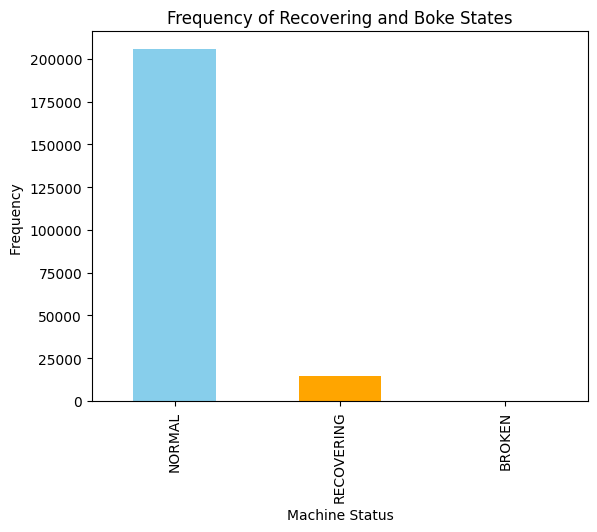

In [17]:
# Bar plot
value_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Frequency of Recovering and Boke States')
plt.xlabel('Machine Status')
plt.ylabel('Frequency ')
plt.show()

## Machine Status (Target Variable) Over Observations

In [18]:
# Mapping target variable's classes to numeric values
status_mapping = {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}
df['status_mapped'] = df['machine_status'].map(status_mapping)

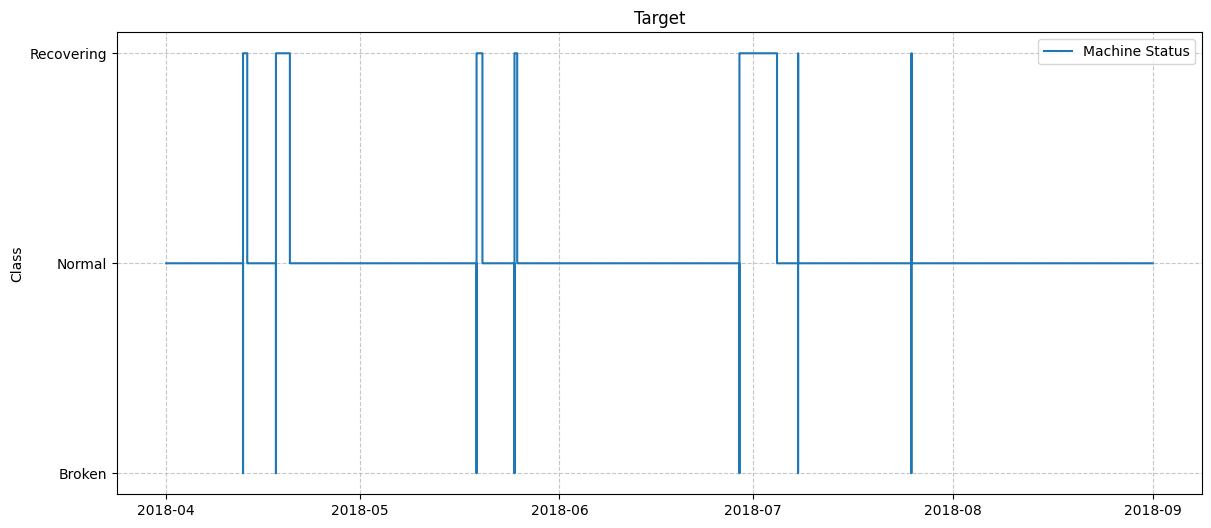

In [19]:
plt.figure(figsize=(14, 6))

plt.step(df.index, df['status_mapped'], label='Machine Status', where='mid')

# Set y-ticks to reflect all statuses
plt.yticks([0, 1, 2], ['Broken', 'Normal', 'Recovering'])

plt.ylabel('Class')
plt.title('Target')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

The Recovering class consistently follows the Broken class, which means that having only 7 entries for the Broken class is not a problem. By predicting the Recovering phase, we can also predict the Broken class.

In [20]:
# Combine Broken and Recovering into a single category
df['machine_status'] = df['machine_status'].replace({'RECOVERING': 'BROKEN'})
status_mapping = {'BROKEN': 1, 'NORMAL': 0}
df['status_mapped'] = df['machine_status'].map(status_mapping)

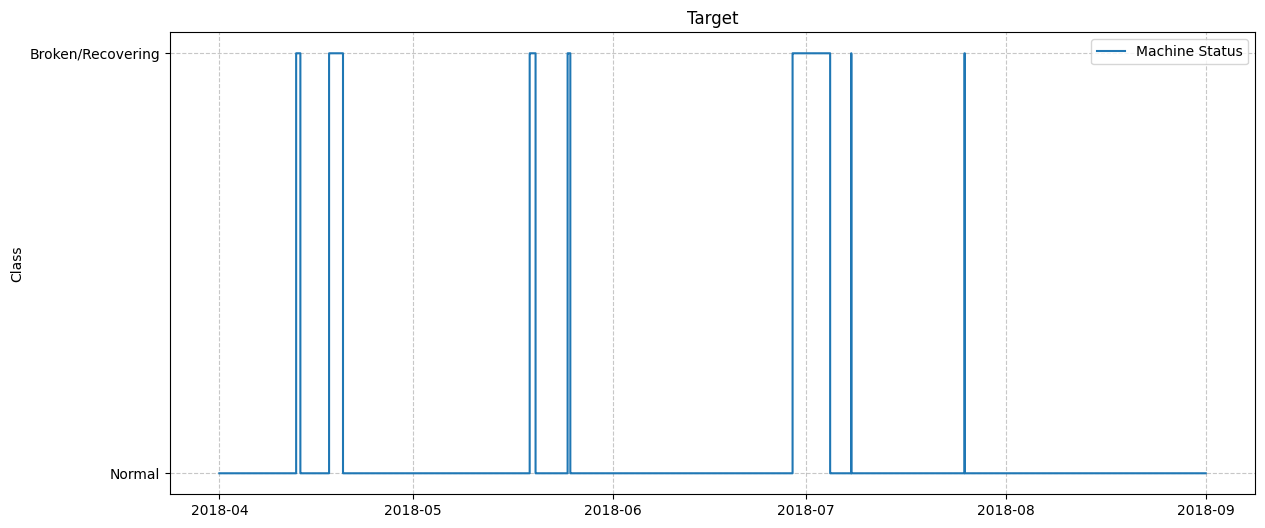

In [21]:
plt.figure(figsize=(14, 6))

plt.step(df.index, df['status_mapped'], label='Machine Status', where='mid')

# Set y-ticks to reflect all statuses
plt.yticks([0, 1], ['Normal', 'Broken/Recovering'])

plt.ylabel('Class')
plt.title('Target')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Zero Value Analysis for Sensors

In [22]:
# Define sensor columns
sensor_columns = [col for col in df.columns if 'sensor' in col]

# Find sensors with minimum value of 0
sensors_with_zero_min = [col for col in sensor_columns if df[col].min() == 0]
sensor_count_with_zero_min = len(sensors_with_zero_min)

# Calculate the zero percentage, total count of zero values, count of zero values when machine_status is not "NORMAL", and count of NaN values for each sensor
zero_statistics = {
    col: {
        "Zero_Percentage": (df[col] == 0).mean() * 100,
        "Zero_Count": (df[col] == 0).sum(),
        "Non_Normal_Zero_Count": df[(df['machine_status'] != 'NORMAL') & (df[col] == 0)].shape[0],
        "NaN_Count": df[col].isna().sum()
    }
    for col in sensors_with_zero_min
}

# Convert the dictionary to a DataFrame
zero_statistics_df = pd.DataFrame.from_dict(zero_statistics, orient='index').reset_index().sort_values(by='Zero_Percentage', ascending=False)
zero_statistics_df.columns = ['Sensor', 'Zero_Percentage', 'Zero_Count', 'Non_Normal_Zero_Count', 'NaN_Count']

print("Sensors with minimum value of 0:", sensors_with_zero_min)
print("Count of sensors with minimum value of 0:", sensor_count_with_zero_min)
print("\nZero Percentage, Count, Non-NORMAL Zero Count, and NaN Count for Each Sensor:")
print(zero_statistics_df)

Sensors with minimum value of 0: ['sensor_00', 'sensor_01', 'sensor_05', 'sensor_07', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_27', 'sensor_30', 'sensor_35', 'sensor_37']
Count of sensors with minimum value of 0: 22

Zero Percentage, Count, Non-NORMAL Zero Count, and NaN Count for Each Sensor:
       Sensor  Zero_Percentage  Zero_Count  Non_Normal_Zero_Count  NaN_Count
12  sensor_19             7.58       16692                      4         16
8   sensor_13             6.87       15142                  13932         19
11  sensor_18             6.82       15021                      0         46
10  sensor_17             6.78       14940                      0         46
14  sensor_22             6.68       14725                      0         41
21  sensor_37             6.53       14395                    112         16
17  sensor_25    

In [23]:
# Identifying anomalous zero values in sensor data using z-scores
from scipy.stats import zscore

for sensor_column in sensors_with_zero_min:
    df['is_zero'] = (df[sensor_column] == 0).astype(int)
    # Calculate z-scores and check if zeros are anomalies
    df['z_score'] = zscore(df[sensor_column].replace(0, np.nan))
    df['is_anomaly'] = np.abs(df['z_score']) > 2  # z > 2 is considered an anomaly

print(len(df[df['is_anomaly'] == True]))
del df['is_zero']
del df['z_score']
del df['is_anomaly']

0


There is no anomalies detected among the observations with zero values across the sensors.

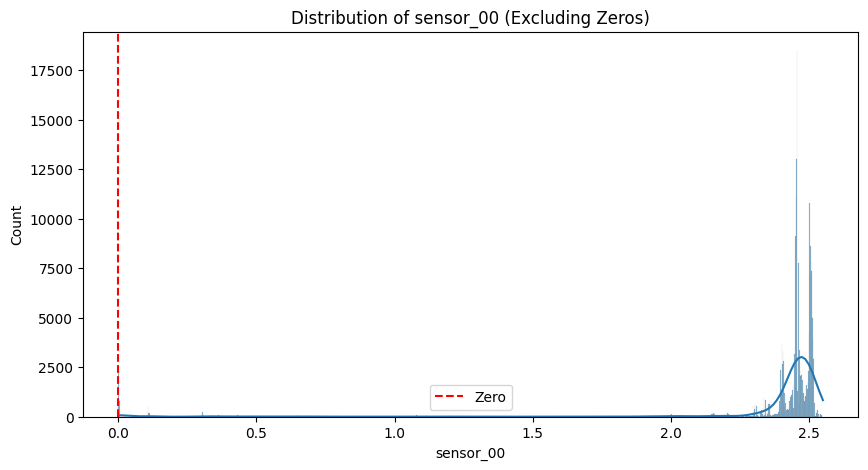

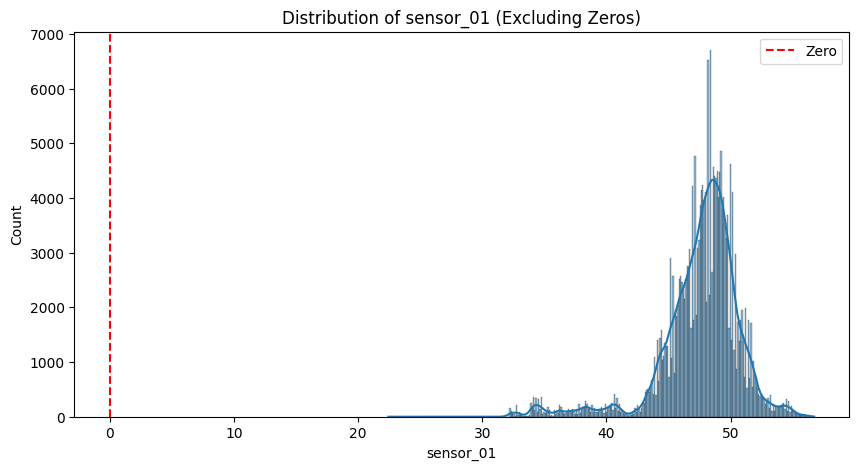

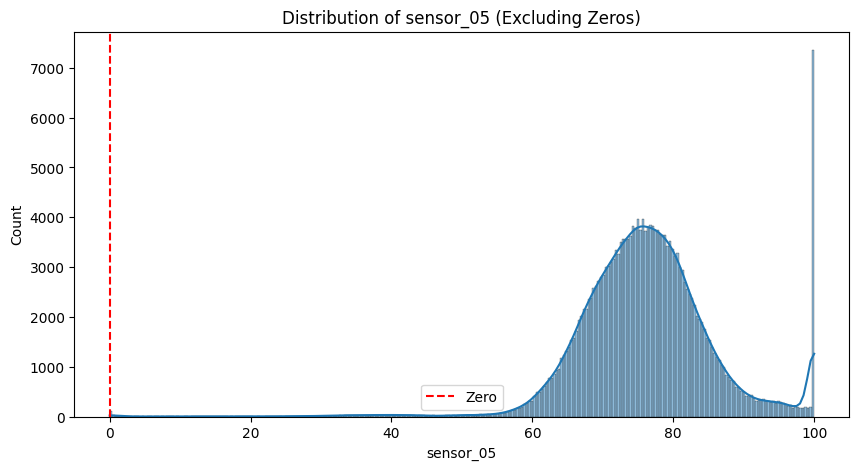

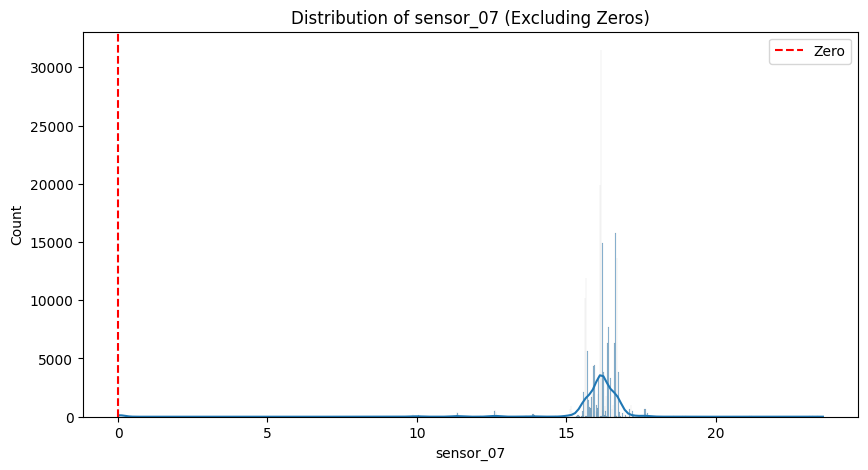

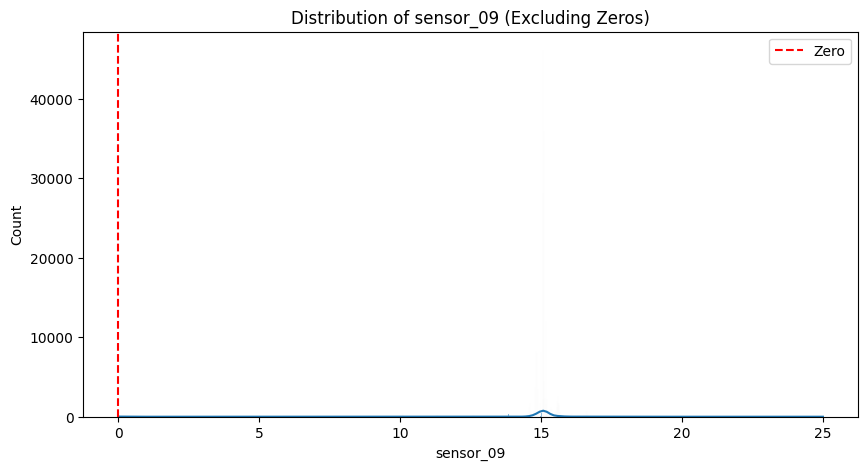

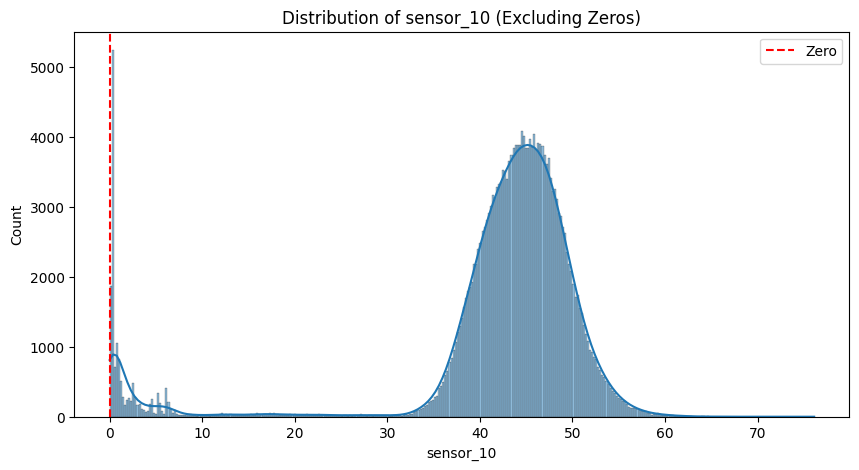

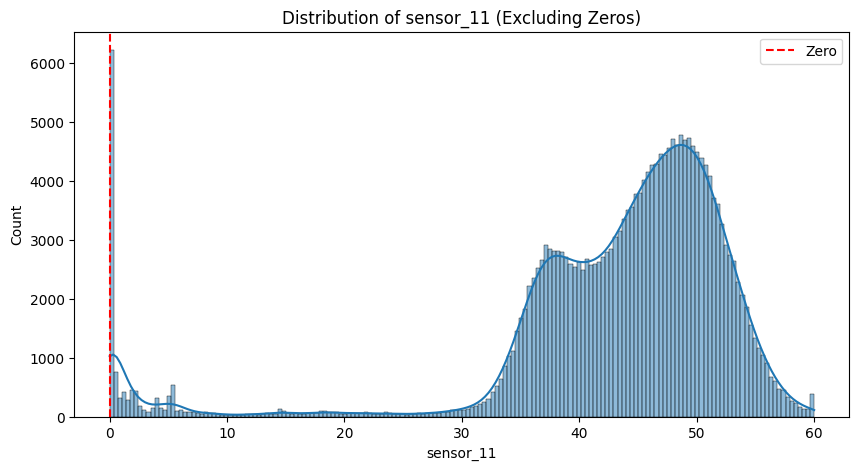

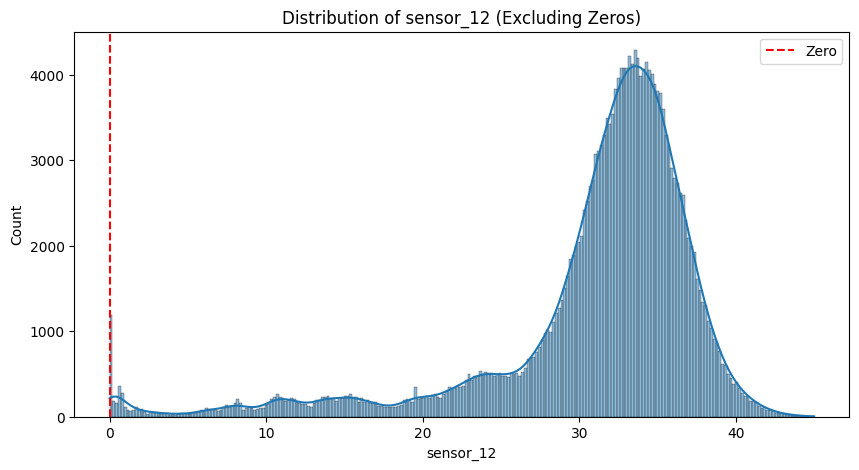

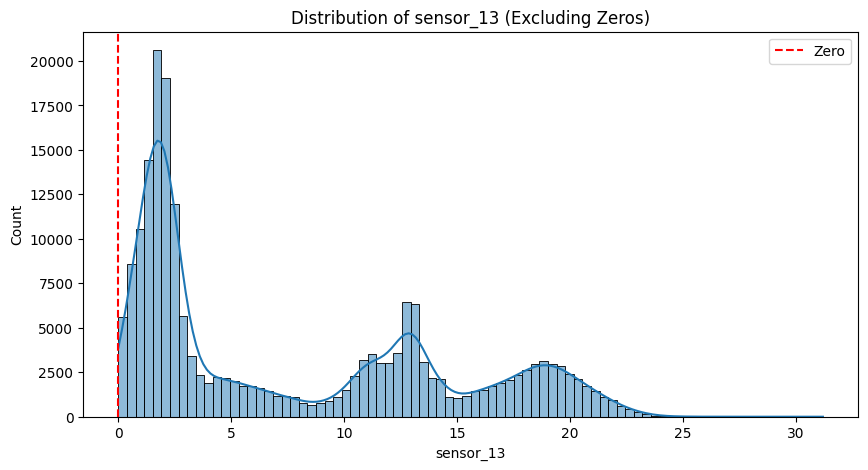

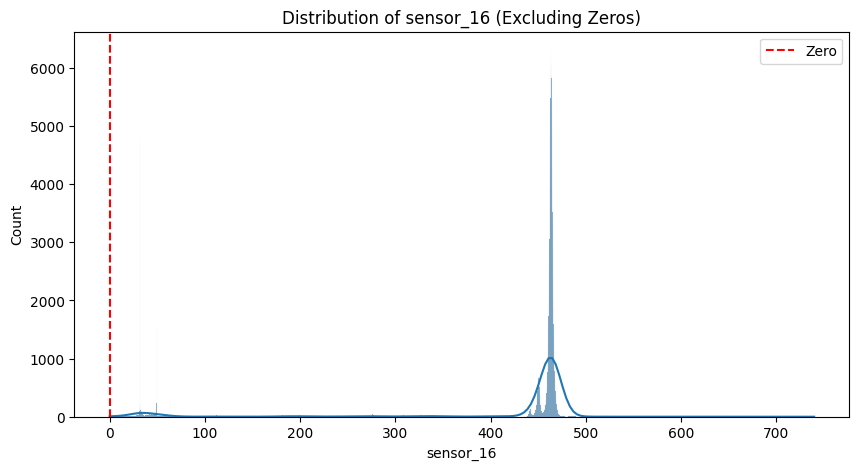

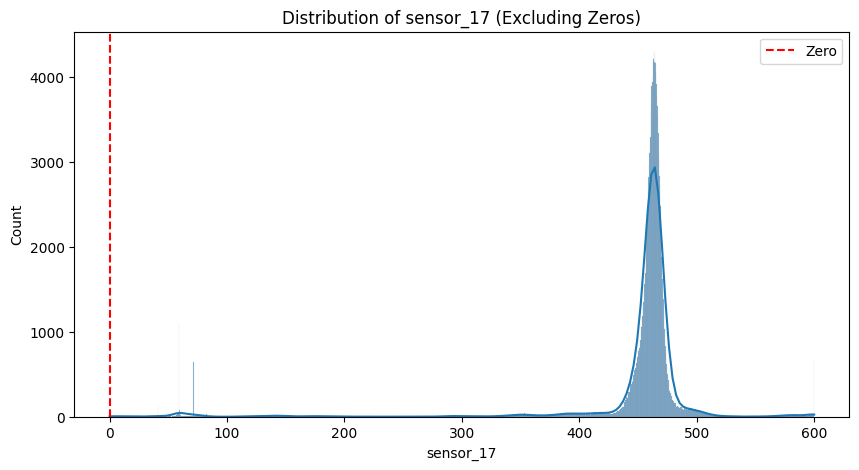

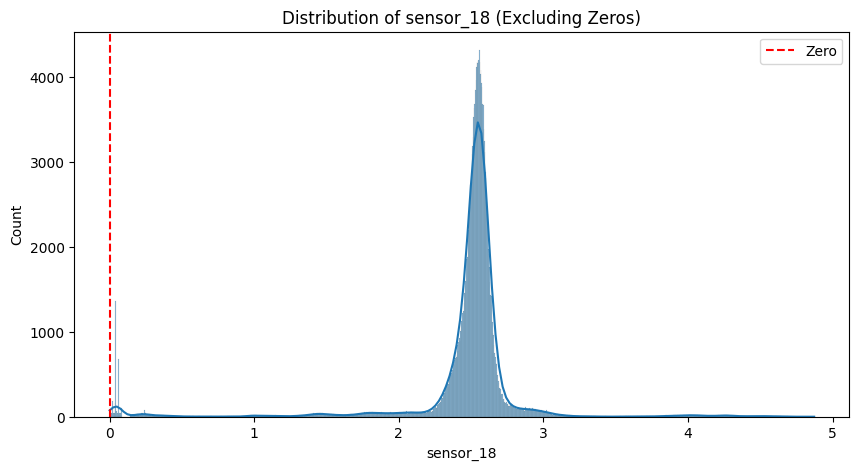

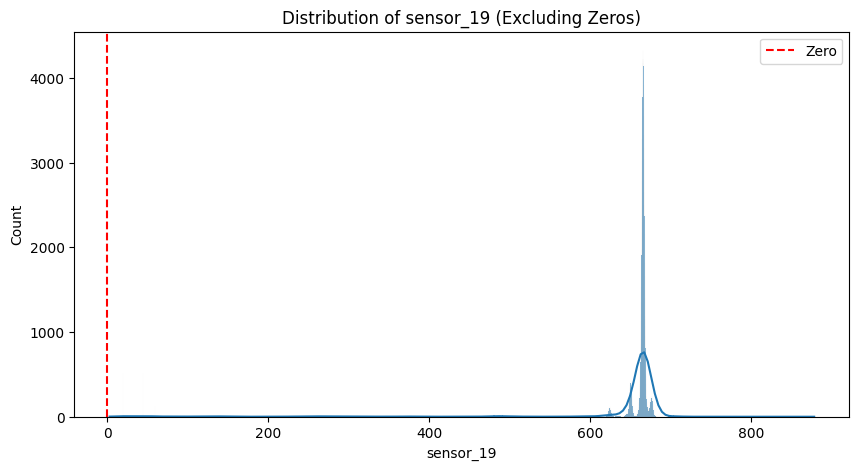

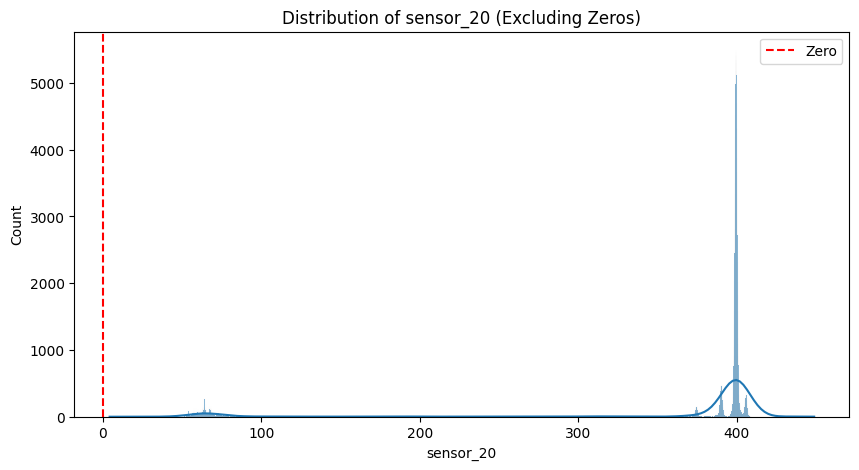

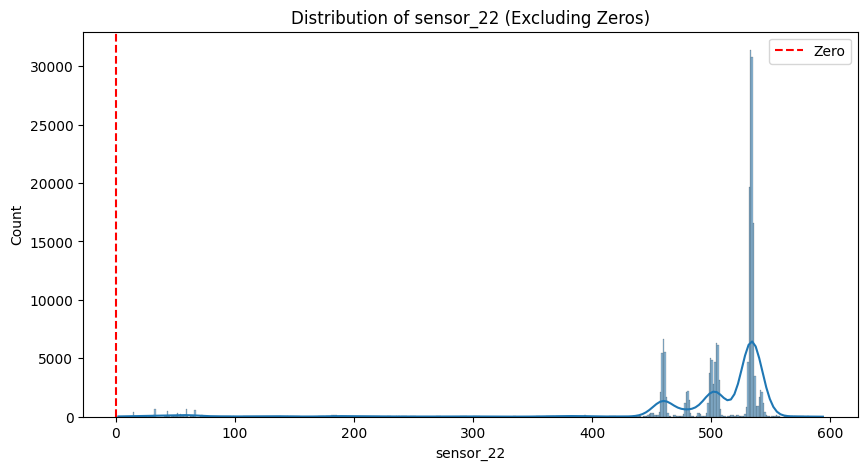

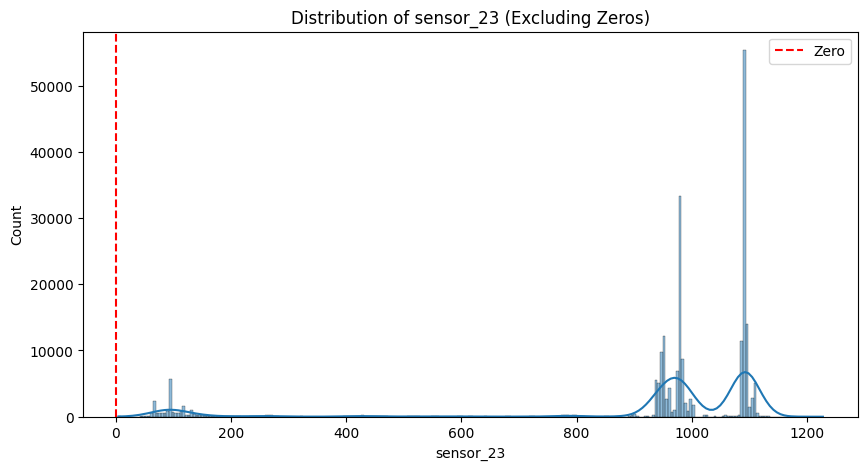

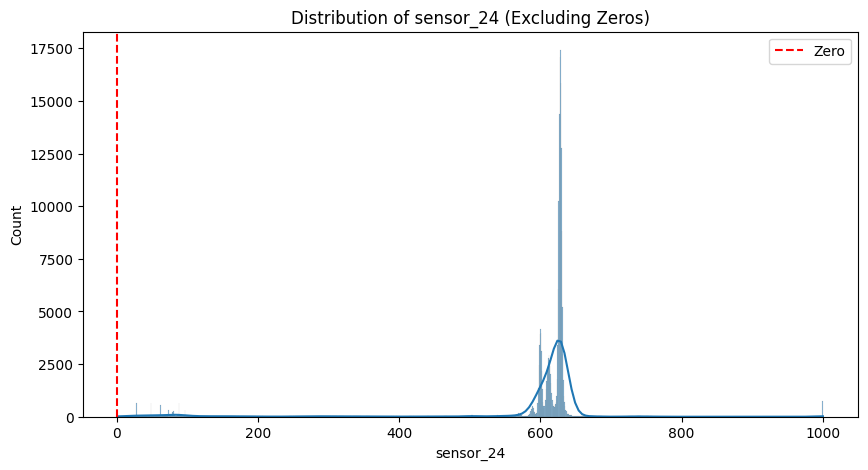

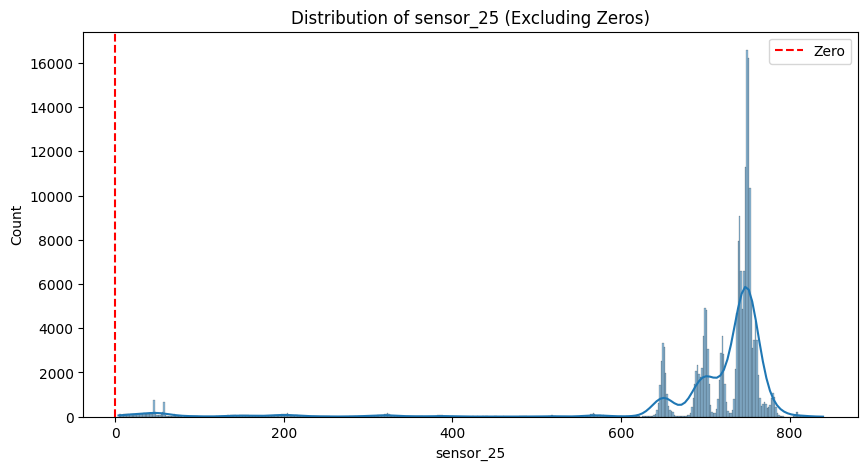

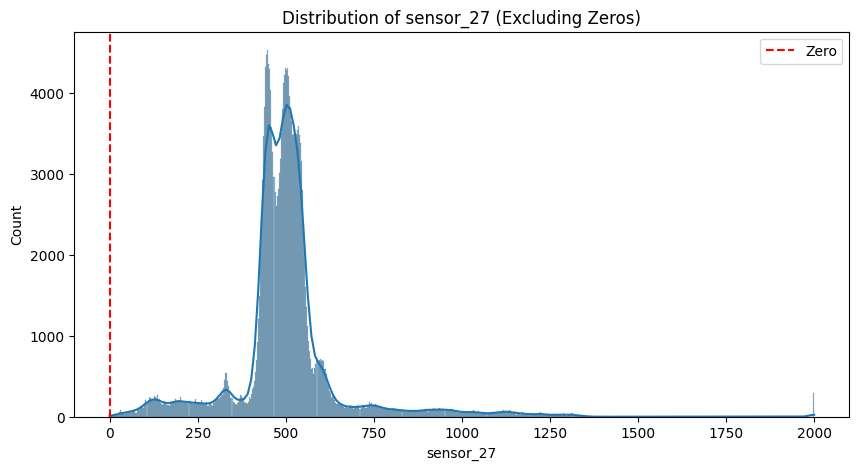

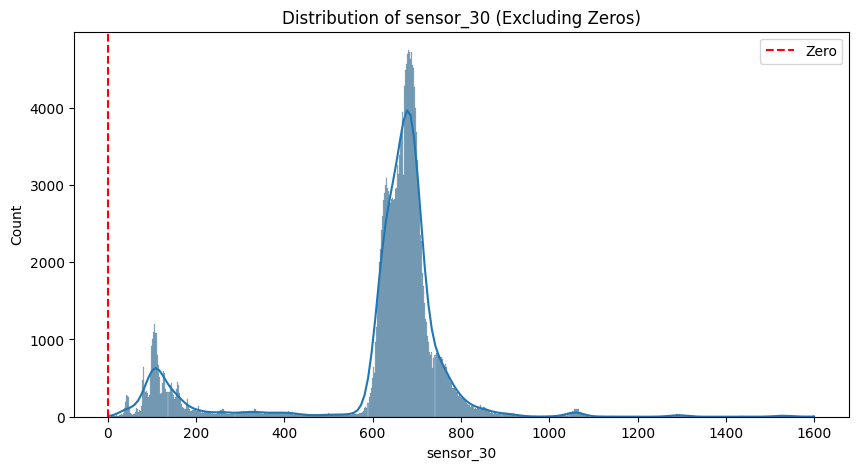

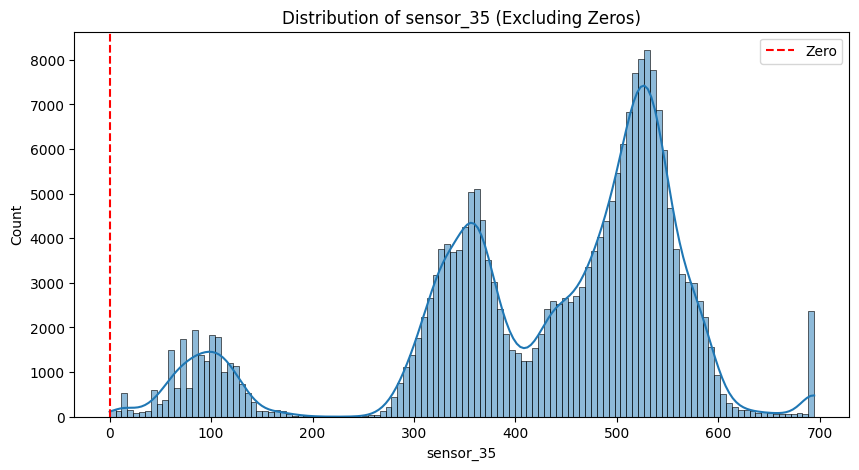

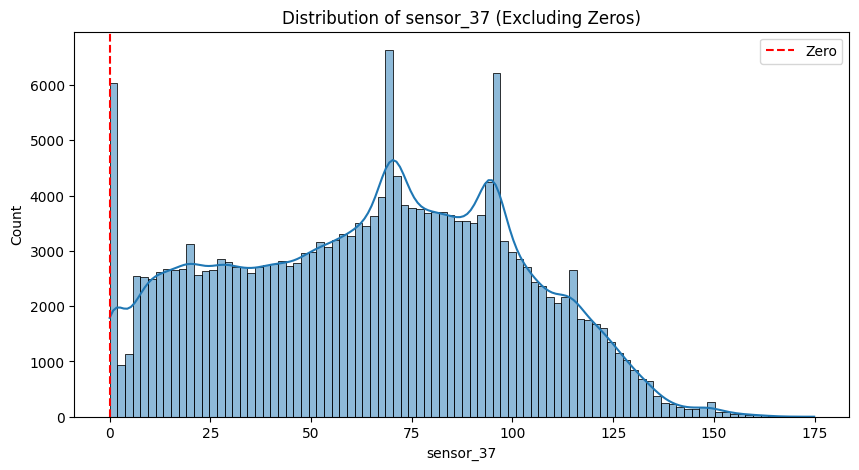

In [24]:
# Examine the distribution of sensor values
for sensor_column in sensors_with_zero_min:
    plt.figure(figsize=(10, 5))
    if sensor_column not in ['machine_status', 'status_mapped']:
        sns.histplot(df[sensor_column][df[sensor_column] != 0], kde=True)
        plt.axvline(0, color='red', linestyle='--', label='Zero')
        plt.title(f'Distribution of {sensor_column} (Excluding Zeros)')
        plt.legend()
        plt.show()

If the zero value appears outside the distribution range, it can be considered as NaN. If it looks like part of the distribution, it can remain as zero.

* For certain sensors (sensor_01, sensor_20), the value 0 appears to lie outside the expected distribution range. This suggests that 0 might represent a missing or erroneous measurement rather than a valid reading. Therefore, we want to treat these 0 values as NaN (missing values) for subsequent data cleaning and imputation processes.

In [25]:
# List of sensors where 0 is treated as NaN
sensors_to_check = ['sensor_01', 'sensor_20']

# Replace 0 with NaN for the specified sensors
df[sensors_to_check] = df[sensors_to_check].replace(0, np.nan)

## Missing Values

In [26]:
# Drops sensor_15 due to complete lack of data
df.drop('sensor_15', axis = 1, inplace = True)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col != 'status_mapped']

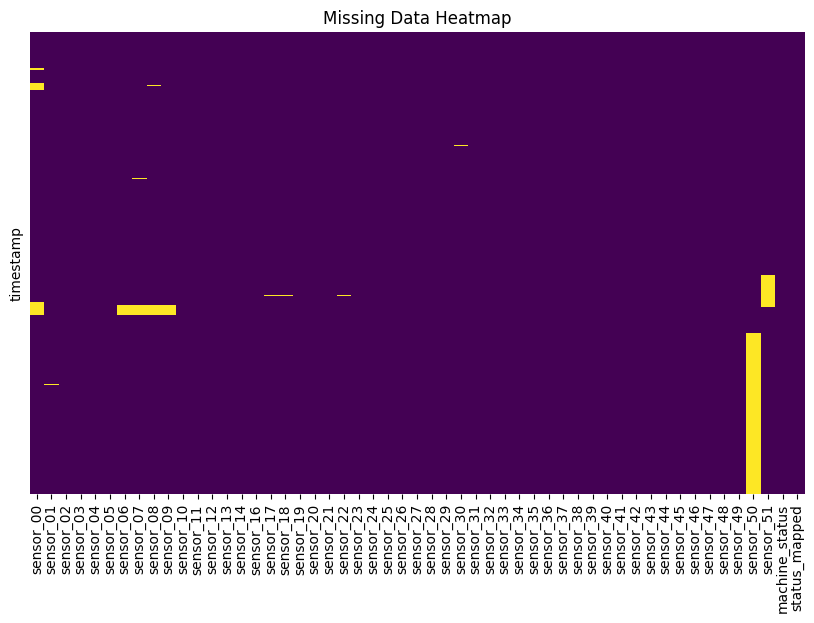

In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

In [28]:
na_cols = missing_values_table(df, na_name=True)

           n_miss  ratio
sensor_50   77017  34.96
sensor_51   15383   6.98
sensor_00   10208   4.63
sensor_07    5451   2.47
sensor_08    5107   2.32
sensor_06    4798   2.18
sensor_09    4595   2.09
sensor_01     373   0.17
sensor_30     261   0.12
sensor_20     118   0.05
sensor_29      72   0.03
sensor_32      68   0.03
sensor_17      46   0.02
sensor_18      46   0.02
sensor_22      41   0.02
sensor_25      36   0.02
sensor_16      31   0.01
sensor_42      27   0.01
sensor_39      27   0.01
sensor_46      27   0.01
sensor_38      27   0.01
sensor_45      27   0.01
sensor_47      27   0.01
sensor_44      27   0.01
sensor_43      27   0.01
sensor_48      27   0.01
sensor_41      27   0.01
sensor_40      27   0.01
sensor_49      27   0.01
sensor_14      21   0.01
sensor_26      20   0.01
sensor_02      19   0.01
sensor_03      19   0.01
sensor_05      19   0.01
sensor_10      19   0.01
sensor_11      19   0.01
sensor_12      19   0.01
sensor_04      19   0.01
sensor_13      19   0.01


In [29]:
# Examination of the Relationship Between Missing Values and the target variable
for col in na_cols:
    result = missing_vs_target(df, col, 'machine_status')
    print('\n' + '#'*5 + ' ' +  col + ' ' + '#'*5 + '\n')
    print(result)


##### sensor_00 #####

                Missing Count  Total Count  Missing Ratio (%)
machine_status                                               
BROKEN                  10194        14484              70.38
NORMAL                     14       205836               0.01

##### sensor_01 #####

                Missing Count  Total Count  Missing Ratio (%)
machine_status                                               
BROKEN                     30        14484               0.21
NORMAL                    343       205836               0.17

##### sensor_02 #####

                Missing Count  Total Count  Missing Ratio (%)
machine_status                                               
BROKEN                      5        14484               0.03
NORMAL                     14       205836               0.01

##### sensor_03 #####

                Missing Count  Total Count  Missing Ratio (%)
machine_status                                               
BROKEN                      5       

**Imbalance in Missing Data Across machine_status:**

* The missing ratios are significantly higher for observations where machine_status is BROKEN compared to those marked as NORMAL. This indicates a potential dependency between missingness and the target variable.

**Specific Sensors with High Missing Ratios:**

* Some sensors exhibit a high proportion of missing values for BROKEN status:
  * sensor_00: Missing in 70.38% of BROKEN cases.
  * sensor_06, sensor_07, sensor_08, and sensor_09: Missing in 30–40% of BROKEN cases.
  * sensor_51: Missing in 20.7% of BROKEN cases.
* These sensors might be critical indicators of machine failure, as they exhibit more missing values during failures.

In [30]:
# Drops sensor_00 due to high missing values (70.38%) specifically in BROKEN cases
df.drop('sensor_00', axis = 1, inplace = True)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col != 'status_mapped']

In [31]:
na_cols = missing_values_table(df, na_name=True)

           n_miss  ratio
sensor_50   77017  34.96
sensor_51   15383   6.98
sensor_07    5451   2.47
sensor_08    5107   2.32
sensor_06    4798   2.18
sensor_09    4595   2.09
sensor_01     373   0.17
sensor_30     261   0.12
sensor_20     118   0.05
sensor_29      72   0.03
sensor_32      68   0.03
sensor_17      46   0.02
sensor_18      46   0.02
sensor_22      41   0.02
sensor_25      36   0.02
sensor_16      31   0.01
sensor_48      27   0.01
sensor_43      27   0.01
sensor_39      27   0.01
sensor_40      27   0.01
sensor_41      27   0.01
sensor_42      27   0.01
sensor_44      27   0.01
sensor_47      27   0.01
sensor_38      27   0.01
sensor_49      27   0.01
sensor_46      27   0.01
sensor_45      27   0.01
sensor_14      21   0.01
sensor_26      20   0.01
sensor_03      19   0.01
sensor_05      19   0.01
sensor_10      19   0.01
sensor_11      19   0.01
sensor_12      19   0.01
sensor_13      19   0.01
sensor_04      19   0.01
sensor_02      19   0.01
sensor_34      16   0.01


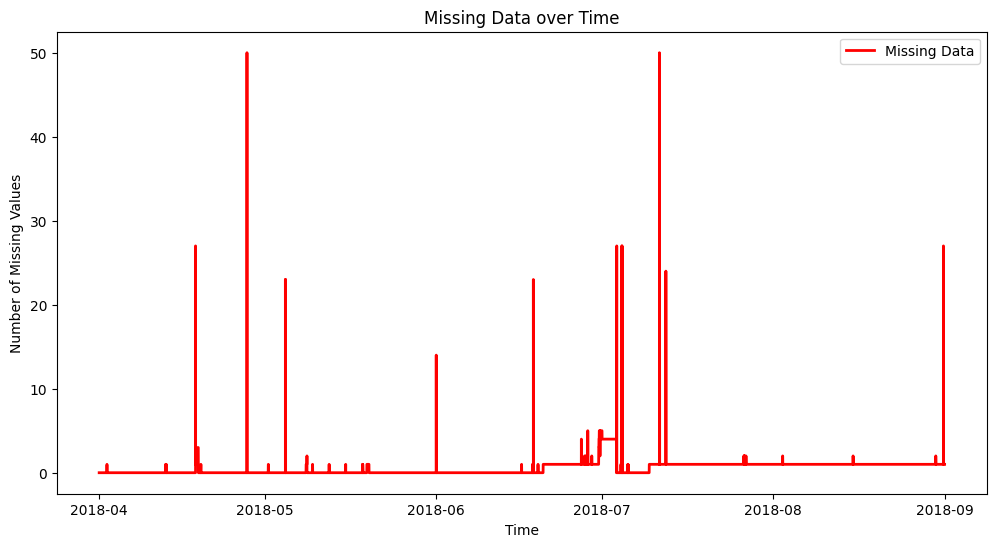

In [32]:
plt.figure(figsize=(12, 6))
missing_data = df.isnull().sum(axis=1)
plt.plot(df.index, missing_data, label='Missing Data', color='red', lw=2)
plt.title('Missing Data over Time')
plt.xlabel('Time')
plt.ylabel('Number of Missing Values')
plt.legend()
plt.show()

 ### Approach to Handling Missing Values Based on Their Proportions

 *  For sensors with a very small proportion of missing data, forward-fill (ffill) or backward-fill (bfill) is effective because the gaps are minor, and nearby values are likely to provide reasonable estimates.
 *  K-Nearest Neighbors (KNN) imputation considers correlations between sensors, making it a robust choice for filling moderate missing values. It uses information from the most similar rows (neighbors) to impute the missing values.
 *  Linear interpolation works well when there's a clear temporal or sequential trend in the data. It estimates missing values by connecting adjacent points with straight lines.

In [33]:
for sensor in na_cols:
# For sensors with low missing ratios (<1%), use forward fill or backward fill
    missing_ratio = df[sensor].isnull().sum() / len(df) * 100
    if missing_ratio <= 1:
        df[sensor] = df[sensor].ffill().bfill()
# For high missing ratios (>=30%), apply interpolation
    elif missing_ratio >= 30:
        df[sensor] = df[sensor].interpolate(method='linear')
# For low-to-moderate missing ratio (1%-30%), apply KNN imputation
    elif 1 < missing_ratio < 30:
        knn_imputer = KNNImputer(n_neighbors=3)
        df[[sensor]] = knn_imputer.fit_transform(df[[sensor]])

na_cols = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [34]:
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220320, 52)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Freq: min
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_01       220320 non-null  float64
 1   sensor_02       220320 non-null  float64
 2   sensor_03       220320 non-null  float64
 3   sensor_04       220320 non-null  float64
 4   sensor_05       220320 non-null  float64
 5   sensor_06       220320 non-null  float64
 6   sensor_07       220320 non-null  float64
 7   sensor_08       220320 non-null  float64
 8   sensor_09       220320 non-null  float64
 9   sensor_10       220320 non-null  float64
 10  sensor_11       220320 non-null  float64
 11  sensor_12       220320 non-null  float64
 12  sensor_13       220320 non-null  float64
 13  sensor_14

## Outliers Analysis

In [35]:
# Identify columns with outliers
outlier_cols = [col for col in num_cols if check_outlier(df, col)]
print(f"Counts the number of columns with detected outliers: {len(outlier_cols)}")
print("Columns with Detected Outliers")
outlier_cols

Counts the number of columns with detected outliers: 19
Columns with Detected Outliers


['sensor_01',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_27',
 'sensor_33',
 'sensor_38',
 'sensor_39',
 'sensor_40',
 'sensor_41',
 'sensor_42',
 'sensor_43',
 'sensor_44',
 'sensor_45',
 'sensor_46',
 'sensor_47',
 'sensor_49',
 'sensor_51']

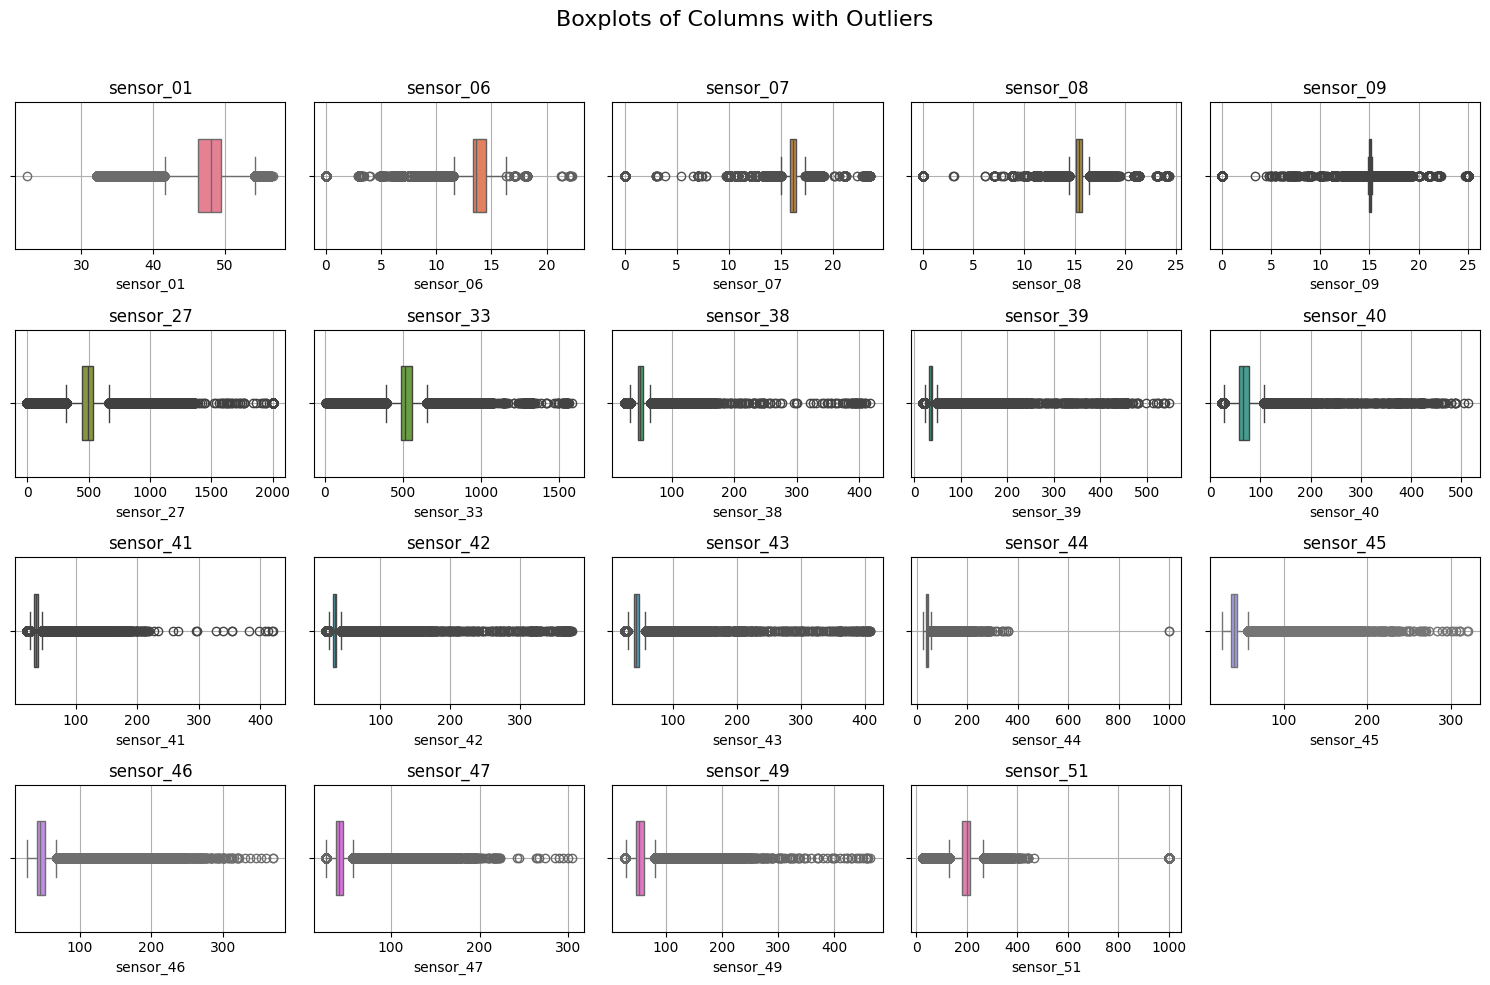

In [36]:
# Set colors for the plots
colors = sns.color_palette("husl", len(outlier_cols))

# Determine the number of columns and rows for the grid
n_cols = 5
n_rows = int(np.ceil(len(outlier_cols) / n_cols))

# Create the subplots figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2.5))
fig.suptitle('Boxplots of Columns with Outliers', fontsize=16)
axes = axes.flatten()  # Flatten to easily iterate over axes

# Plot each column with outliers as a boxplot
for i, col in enumerate(outlier_cols):
    sns.boxplot(x=df[col], color=colors[i], orient='h', width=0.5, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].grid(True)

# Hide any extra subplots if the number of columns is not a multiple of n_cols
for ax in axes[len(outlier_cols):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the main title
plt.show()


In [37]:
# Outlier Handling Problem - Capping Method (Re-assignment with thresholds)
for col in num_cols:
    replace_with_thresholds(df, col)

In [38]:
outlier_cols = [col for col in num_cols if check_outlier(df, col)]
print(f"Counts the number of columns with detected outliers: {len(outlier_cols)}")

Counts the number of columns with detected outliers: 0


## Correlation Analysis

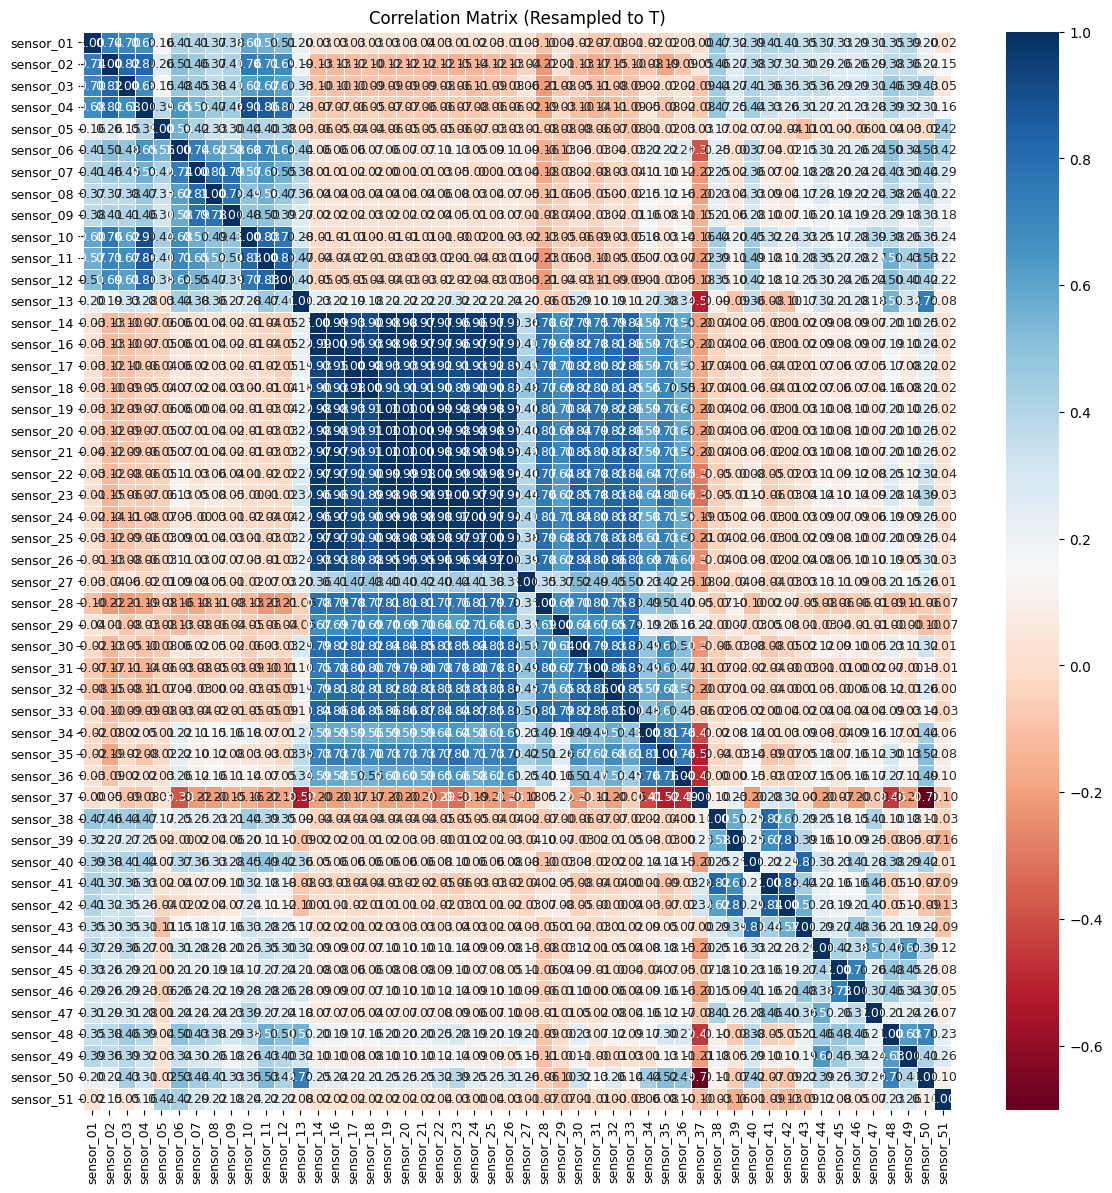

In [39]:
# We are going to focus on the minute-level analysis because we are interested in very short-term dependencies like detecting rapid cahanges/minute level anomalies.
drop_list_Minute = high_correlated_cols_time_series(df[num_cols], plot = True, resample_freq="T")

In [40]:
print(f"Counts the number of columns with detected high correlated columns: {drop_list_Minute}")
len(drop_list_Minute)

Counts the number of columns with detected high correlated columns: ['sensor_10', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']


12

In [41]:
high_correlated_cols_time_series(df[num_cols].drop(drop_list_Minute, axis=1))
df = df.drop(drop_list_Minute, axis=1)

In [42]:
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220320, 40)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Freq: min
Data columns (total 40 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_01       220320 non-null  float64
 1   sensor_02       220320 non-null  float64
 2   sensor_03       220320 non-null  float64
 3   sensor_04       220320 non-null  float64
 4   sensor_05       220320 non-null  float64
 5   sensor_06       220320 non-null  float64
 6   sensor_07       220320 non-null  float64
 7   sensor_08       220320 non-null  float64
 8   sensor_09       220320 non-null  float64
 9   sensor_11       220320 non-null  float64
 10  sensor_12       220320 non-null  float64
 11  sensor_13       220320 non-null  float64
 12  sensor_14       220320 non-null  float64
 13  sensor_27

In [43]:
df.to_csv('/content/drive/MyDrive/cleaned_sensor_data.csv')

# Feature Engineering

In [44]:
# df = pd.read_csv('/content/drive/MyDrive/cleaned_sensor_data.csv')

### Find the sensors that have a correlation greater than 0.3 with the target variable.

In [45]:
# Compute correlation with target
correlations = df[[col for col in df.columns if 'sensor' in col] + ['status_mapped']].corr()
sensor_correlations = correlations['status_mapped'].drop('status_mapped').abs()

# Set a threshold for critical sensors
critical_threshold = 0.3  # Sensors with correlation > 0.3
critical_sensors = sensor_correlations[sensor_correlations > critical_threshold].index.tolist()

print("Critical Sensors based on correlation with target:", len(critical_sensors))

Critical Sensors based on correlation with target: 16


#### Rolling Window Features
Rolling mean, median, and standard deviation: This helps capture short-term trends and smoothing while still reacting quickly to changes.

In [46]:
rolling_window = 15 # 15-minute rolling window for short-term analysis(to capture rapid changes)
for sensor in critical_sensors:
    df[sensor + '_rolling_mean'] = df[sensor].rolling(window=rolling_window).mean()
    df[sensor + '_rolling_std'] = df[sensor].rolling(window=rolling_window).std()
    df[sensor + '_rolling_median'] = df[sensor].rolling(window=rolling_window).median()

#### Lag Features
Create lag features for immediate past values. These will help detect short-term dependencies and identify sudden changes that might signal anomalies.

In [47]:
for sensor in critical_sensors:
    df[sensor + '_lag_1min'] = df[sensor].shift(1)  # 1-minute lag
    df[sensor + '_lag_5min'] = df[sensor].shift(5)
    df[sensor + '_lag_10min'] = df[sensor].shift(10)

#### Differencing (Rate of Change)
   Calculate the difference between consecutive observations to capture the rate of change (important for detecting sudden shifts in values).

In [48]:
for sensor in critical_sensors:
    df[sensor + '_diff_1min'] = df[sensor].diff(periods=1)  # Difference between current and previous minute
    df[sensor + '_diff_5min'] = df[sensor].diff(periods=5)  # Difference over 5 minutes
    df[sensor + '_diff_10min'] = df[sensor].diff(periods=10)

#### Exponential Moving Average (EMA)
Apply an exponential moving average (EMA) with a small span to give more weight to the recent values while still capturing trends.

In [49]:
for sensor in critical_sensors:
    df[sensor + '_ema'] = df[sensor].ewm(span=rolling_window).mean()

#### Anomaly Detection Features
Use anomaly detection techniques that help identify outliers or significant deviations. Calculate the z-score (how many standard deviations away a value is from the mean), which can help identify rapid, minute-level anomalies.

In [50]:
for sensor in critical_sensors:
    df[sensor + '_z_score'] = (df[sensor] - df[sensor].mean()) / df[sensor].std()

#### Rolling Quantile Features
Calculate rolling quantiles to capture upper bounds of sensor behavior. This helps identify if values are near the maximum threshold within a short window.

In [51]:
for sensor in critical_sensors:
    df[sensor + '_rolling_90th'] = df[sensor].rolling(window=rolling_window).quantile(0.9)

#### Trend Detection with Difference
For rapid detection of a rising or falling trend, compute differences over time intervals to identify the rate of increase or decrease in sensor readings

In [52]:
for sensor in critical_sensors:
    df[sensor + '_5min_diff'] = df[sensor].diff(periods=5)  # Detect trends over a 5-minute window
    df[sensor + '_10min_diff'] = df[sensor].diff(periods=10)
    df[sensor + '_15min_diff'] = df[sensor].diff(periods=15)

#### Peak and Trough Detection
Identify when a sensor value exceeds or drops below a certain threshold (based on recent statistics), to spot peaks or troughs that might signal an anomaly.

In [53]:
for sensor in critical_sensors:
    df[sensor + '_peak'] = (df[sensor] > df[sensor].rolling(window=5).max())  # Flag peak values
    df[sensor + '_trough'] = (df[sensor] < df[sensor].rolling(window=5).min())  # Flag trough values

#### Time-based Features
Focuse on minute-level analysis, adding minute-specific time features might help to see if there are patterns linked to specific minutes of each hour.

In [54]:
df.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,status_mapped,sensor_01_rolling_mean,sensor_01_rolling_std,sensor_01_rolling_median,sensor_02_rolling_mean,sensor_02_rolling_std,sensor_02_rolling_median,sensor_03_rolling_mean,sensor_03_rolling_std,sensor_03_rolling_median,sensor_04_rolling_mean,sensor_04_rolling_std,sensor_04_rolling_median,sensor_05_rolling_mean,sensor_05_rolling_std,sensor_05_rolling_median,sensor_06_rolling_mean,sensor_06_rolling_std,sensor_06_rolling_median,sensor_07_rolling_mean,sensor_07_rolling_std,sensor_07_rolling_median,sensor_08_rolling_mean,sensor_08_rolling_std,sensor_08_rolling_median,sensor_09_rolling_mean,sensor_09_rolling_std,sensor_09_rolling_median,sensor_11_rolling_mean,sensor_11_rolling_std,sensor_11_rolling_median,sensor_12_rolling_mean,sensor_12_rolling_std,sensor_12_rolling_median,sensor_38_rolling_mean,sensor_38_rolling_std,sensor_38_rolling_median,sensor_40_rolling_mean,sensor_40_rolling_std,sensor_40_rolling_median,sensor_41_rolling_mean,sensor_41_rolling_std,sensor_41_rolling_median,sensor_48_rolling_mean,sensor_48_rolling_std,sensor_48_rolling_median,sensor_49_rolling_mean,sensor_49_rolling_std,sensor_49_rolling_median,sensor_01_lag_1min,sensor_01_lag_5min,sensor_01_lag_10min,sensor_02_lag_1min,sensor_02_lag_5min,sensor_02_lag_10min,sensor_03_lag_1min,sensor_03_lag_5min,sensor_03_lag_10min,sensor_04_lag_1min,sensor_04_lag_5min,sensor_04_lag_10min,sensor_05_lag_1min,sensor_05_lag_5min,sensor_05_lag_10min,sensor_06_lag_1min,sensor_06_lag_5min,sensor_06_lag_10min,sensor_07_lag_1min,sensor_07_lag_5min,sensor_07_lag_10min,sensor_08_lag_1min,sensor_08_lag_5min,sensor_08_lag_10min,sensor_09_lag_1min,sensor_09_lag_5min,sensor_09_lag_10min,sensor_11_lag_1min,sensor_11_lag_5min,sensor_11_lag_10min,sensor_12_lag_1min,sensor_12_lag_5min,sensor_12_lag_10min,sensor_38_lag_1min,sensor_38_lag_5min,sensor_38_lag_10min,sensor_40_lag_1min,sensor_40_lag_5min,sensor_40_lag_10min,sensor_41_lag_1min,sensor_41_lag_5min,sensor_41_lag_10min,sensor_48_lag_1min,sensor_48_lag_5min,sensor_48_lag_10min,sensor_49_lag_1min,sensor_49_lag_5min,sensor_49_lag_10min,sensor_01_diff_1min,sensor_01_diff_5min,sensor_01_diff_10min,sensor_02_diff_1min,sensor_02_diff_5min,sensor_02_diff_10min,sensor_03_diff_1min,sensor_03_diff_5min,sensor_03_diff_10min,sensor_04_diff_1min,sensor_04_diff_5min,sensor_04_diff_10min,sensor_05_diff_1min,sensor_05_diff_5min,sensor_05_diff_10min,sensor_06_diff_1min,sensor_06_diff_5min,sensor_06_diff_10min,sensor_07_diff_1min,sensor_07_diff_5min,sensor_07_diff_10min,sensor_08_diff_1min,sensor_08_diff_5min,sensor_08_diff_10min,sensor_09_diff_1min,sensor_09_diff_5min,sensor_09_diff_10min,sensor_11_diff_1min,sensor_11_diff_5min,sensor_11_diff_10min,sensor_12_diff_1min,sensor_12_diff_5min,sensor_12_diff_10min,sensor_38_diff_1min,sensor_38_diff_5min,sensor_38_diff_10min,sensor_40_diff_1min,sensor_40_diff_5min,sensor_40_diff_10min,sensor_41_diff_1min,sensor_41_diff_5min,sensor_41_diff_10min,sensor_48_diff_1min,sensor_48_diff_5min,sensor_48_diff_10min,sensor_49_diff_1min,sensor_49_diff_5min,sensor_49_diff_10min,sensor_01_ema,sensor_02_ema,sensor_03_ema,sensor_04_ema,sensor_05_ema,sensor_06_ema,sensor_07_ema,sensor_08_ema,sensor_09_ema,sensor_11_ema,sensor_12_ema,sensor_38_ema,sensor_40_ema,sensor_41_ema,sensor_48_ema,sensor_49_ema,sensor_01_z_score,sensor_02_z_score,sensor_03_z_score,sensor_04_z_score,sensor_05_z_score,sensor_06_z_score,sensor_07_z_score,sensor_08_z_score,sensor_09_z_score,sensor_11_z_score,sensor_12_z_score,sensor_38_z_score,sensor_40_z_score,sensor_41_z_score,sensor_48_z_score,sensor_49_z_score,sensor_01_rolling_90th,sensor_02_rolling_90th,sensor_0

In [55]:
# Extract components from the timestamp
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

#### Event-Based Features

Time to Failure:
Calculate the time remaining until the next failure, based on the machine_status variable.

In [56]:
df['time_to_failure'] = df['machine_status'].isin(['RECOVERING', 'BROKEN']).cumsum().shift(-1)

Failure Frequency:
Count the number of failures in a given time window.

In [57]:
df['failure_count_hourly'] = df['status_mapped'].rolling('1H').sum()

#### Correlation Analysis After Feature Engineering

In [58]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col != 'status_mapped']

In [59]:
# We are going to focus on the minute-level analysis because we are interested in very short-term dependencies like detecting rapid cahanges/minute level anomalies.
drop_list = high_correlated_cols_time_series(df[num_cols])

In [60]:
print(f"Counts the number of columns with detected high correlated columns: {drop_list}")
len(drop_list)

Counts the number of columns with detected high correlated columns: ['sensor_01_rolling_mean', 'sensor_01_rolling_median', 'sensor_02_rolling_mean', 'sensor_02_rolling_median', 'sensor_03_rolling_mean', 'sensor_03_rolling_median', 'sensor_04_rolling_mean', 'sensor_04_rolling_median', 'sensor_05_rolling_mean', 'sensor_05_rolling_median', 'sensor_06_rolling_mean', 'sensor_06_rolling_median', 'sensor_07_rolling_mean', 'sensor_07_rolling_median', 'sensor_08_rolling_mean', 'sensor_08_rolling_median', 'sensor_09_rolling_mean', 'sensor_09_rolling_median', 'sensor_11_rolling_mean', 'sensor_11_rolling_median', 'sensor_12_rolling_mean', 'sensor_12_rolling_median', 'sensor_38_rolling_mean', 'sensor_38_rolling_median', 'sensor_40_rolling_median', 'sensor_41_rolling_mean', 'sensor_41_rolling_median', 'sensor_48_rolling_mean', 'sensor_48_rolling_median', 'sensor_49_rolling_mean', 'sensor_49_rolling_median', 'sensor_01_lag_1min', 'sensor_01_lag_5min', 'sensor_01_lag_10min', 'sensor_02_lag_1min', 'sen

161

In [61]:
high_correlated_cols_time_series(df[num_cols].drop(drop_list, axis=1), plot=False)
df = df.drop(drop_list, axis=1)
print(f"Dropped columns: {drop_list}")
print(f"Reduced dataset shape: {df.shape}")

Dropped columns: ['sensor_01_rolling_mean', 'sensor_01_rolling_median', 'sensor_02_rolling_mean', 'sensor_02_rolling_median', 'sensor_03_rolling_mean', 'sensor_03_rolling_median', 'sensor_04_rolling_mean', 'sensor_04_rolling_median', 'sensor_05_rolling_mean', 'sensor_05_rolling_median', 'sensor_06_rolling_mean', 'sensor_06_rolling_median', 'sensor_07_rolling_mean', 'sensor_07_rolling_median', 'sensor_08_rolling_mean', 'sensor_08_rolling_median', 'sensor_09_rolling_mean', 'sensor_09_rolling_median', 'sensor_11_rolling_mean', 'sensor_11_rolling_median', 'sensor_12_rolling_mean', 'sensor_12_rolling_median', 'sensor_38_rolling_mean', 'sensor_38_rolling_median', 'sensor_40_rolling_median', 'sensor_41_rolling_mean', 'sensor_41_rolling_median', 'sensor_48_rolling_mean', 'sensor_48_rolling_median', 'sensor_49_rolling_mean', 'sensor_49_rolling_median', 'sensor_01_lag_1min', 'sensor_01_lag_5min', 'sensor_01_lag_10min', 'sensor_02_lag_1min', 'sensor_02_lag_5min', 'sensor_02_lag_10min', 'sensor_03

In [62]:
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220320, 160)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Freq: min
Columns: 160 entries, sensor_01 to is_weekend
dtypes: bool(32), float64(119), int32(6), int64(2), object(1)
memory usage: 218.5+ MB
None

 ############### DataFrame Data Types ############### 

sensor_01                 float64
sensor_02                 float64
sensor_03                 float64
sensor_04                 float64
sensor_05                 float64
sensor_06                 float64
sensor_07                 float64
sensor_08                 float64
sensor_09                 float64
sensor_11                 float64
sensor_12                 float64
sensor_13                 float64
sensor_14                 float64
sensor_27                 float64
sensor_28                 float64
sensor_29                 float6

In [63]:
df.isnull().sum().sum()

734

In [64]:
df = df.dropna()
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220305, 160)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220305 entries, 2018-04-01 00:15:00 to 2018-08-31 23:59:00
Freq: min
Columns: 160 entries, sensor_01 to is_weekend
dtypes: bool(32), float64(119), int32(6), int64(2), object(1)
memory usage: 218.5+ MB
None

 ############### DataFrame Data Types ############### 

sensor_01                 float64
sensor_02                 float64
sensor_03                 float64
sensor_04                 float64
sensor_05                 float64
sensor_06                 float64
sensor_07                 float64
sensor_08                 float64
sensor_09                 float64
sensor_11                 float64
sensor_12                 float64
sensor_13                 float64
sensor_14                 float64
sensor_27                 float64
sensor_28                 float64
sensor_29                 float6

#### Export the Feature Engineered DataFrame

In [65]:
df.to_csv('/content/drive/MyDrive/feature_engineered_sensor_data.csv')

# Dataset Resampling

## Libraries for resampling dataset

In [66]:
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import classification_report

In [67]:
#df = df.sort_values(by='timestamp')

#train_size = int(len(df) * 0.8)

#train_data = df.iloc[:train_size]
#test_data = df.iloc[train_size:]

In [68]:
#X_train = train_data.drop(columns=['machine_status', 'timestamp', 'Unnamed: 0'])
#y_train = train_data['machine_status']

# **Conclusion**
This notebook encompasses a complete pipeline for data preparation, feature engineering, and setting up the dataset for preprocessing and modeling. The workflow achieves the following milestones:

* Data Summary and Initial Inspection: Comprehensive overview functions display essential information about the dataset's structure, types, missing values, and basic statistics.

* Missing Value Analysis: Functions for identifying and examining missing values help assess their impact, allowing for informed decisions on handling or imputing these values.

* Outlier Detection and Treatment: Using quantile-based thresholds, the notebook identifies and caps outliers to mitigate their potential impact on analysis and modeling.

* Correlation Analysis with Resampling: High-correlation features are identified through resampling at different frequencies, along with a heatmap visualization to assess feature redundancy. This step is crucial for time series datasets to manage multicollinearity effectively.

**Feature Engineering:**

The notebook extensively applied feature engineering techniques to derive insights and prepare robust features:

* Critical Sensor Identification:
Selected sensors with correlation above a threshold (0.3) to focus on the most predictive signals.
* Rolling Window Features:
Computed rolling means, medians, and standard deviations to capture short-term trends and smooth noisy sensor data.
* Lag Features:
Created lag features (1, 5, 10 minutes) to identify short-term dependencies and anomalies.
* Differencing:
Calculated rate-of-change features to detect sudden shifts in sensor readings.
* Anomaly Detection:
Applied z-scores and rolling quantiles to identify outliers and behavior extremes.
* Time-Based Features:
Extracted day, hour, minute, and weekday information to capture temporal patterns.
* Event-Based Features:
Computed time-to-failure and rolling failure frequencies to track machine behavior and failures.

These steps provide a robust foundation, addressing data quality issues and uncovering key patterns in the data. The dataset is now well-prepared for the next stage: preprocessing and advanced modeling.